In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import random
from sklearn.metrics import log_loss
import math
from category_encoders import WOEEncoder
from itertools import cycle


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from xgb import XGBClassifier

ModuleNotFoundError: No module named 'xgb'

In [106]:
baskets = pd.read_parquet("baskets.parquet")
coupons = pd.read_parquet("coupons.parquet")
prediction_index = pd.read_parquet("prediction_index.parquet")

In [197]:
sample = baskets[baskets["shopper"] < 2000]

## EDA

In [6]:
print(f"There are {len(np.unique(baskets.shopper))} unique shoppers.")
print(f"There are {len(np.unique(baskets.product))} unique products.")
print(f"There are {len(np.unique(baskets.week))} weeks.")


There are 100000 unique shoppers.
There are 1 unique products.
There are 90 weeks.


Apparently all first purchases happened within the first week. Thus, we have for every customer enough training data.

In [7]:
#lowest amount of data we have for a customer, latest week customer joined
max_ = np.max(baskets.groupby('shopper').min('week').week)
min_ = np.min(baskets.groupby("shopper").product.count())
print(f"The maximum number of first week of a customer is {max_}.")
print(f"Lowest amount of purchases is {min_}.")

The maximum number of first week of a customer is 1.
Lowest amount of purchases is 289.


### Price

In [23]:
baskets[(baskets['product'] == 71) & (baskets['price'] < 629)]

,week,shopper,product,price
2325,0,310,71,534
9305,0,1219,71,377
12945,0,1706,71,471
21009,0,2752,71,566
22202,0,2910,71,440
...,...,...,...,...
68819732,89,97145,71,377
68823709,89,97660,71,377
68825246,89,97861,71,408
68832662,89,98821,71,377


In [25]:
baskets[(baskets['product'] == 71) & (baskets['shopper'] == 12)]

,week,shopper,product,price
3058623,4,12,71,629
13007222,17,12,71,629
17596881,23,12,71,629
21421205,28,12,71,629
45895445,60,12,71,629


In [27]:
coupons[(coupons['product'] == 71) & (coupons.shopper == 12)]

,week,shopper,product,discount
64,0,12,71,10
7500063,15,12,71,35
38500063,77,12,71,25


In [118]:
baskets[(baskets['product'] == 71) & (baskets['shopper'] == 12)]

product  week
0        0       679.217647
         1       679.363341
         2       677.315996
         3       679.709836
         4       680.146993
                    ...    
249      85      493.806038
         86      494.148184
         87      494.468902
         88      493.899022
         89      493.510635
Name: price, Length: 22500, dtype: float64

### Purchased Products

In [107]:
unique_products_per_shopper = baskets.groupby("shopper").product.apply(lambda x: len(np.unique(x)))
products_per_shopper = baskets.groupby("shopper").product.count()

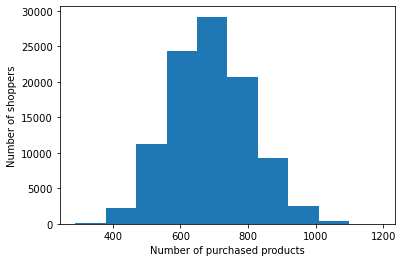

In [9]:
#wenig aussagekräftig
plt.hist(products_per_shopper);
plt.xlabel("Number of purchased products")
plt.ylabel("Number of shoppers");

In [10]:
# in how many weeks did a shopper buy something?
g = sample_b.groupby(["shopper", "week"]).product.count()
# approach did not work, but they most likely bought something in nearly every week

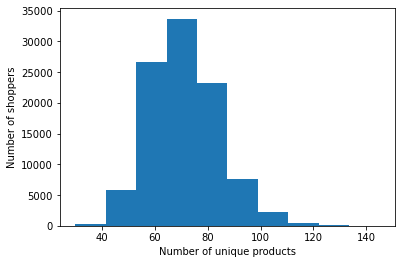

In [11]:
#wieviele verschiedene produkte werden gekauft
#wichtiger: wieviele verschiede produkte werden gekauft in relation zu den insgesamt gekauften produkten
#sample_b.groupby("shopper").product.apply(lambda x: list(np.unique(x)))
plt.hist(unique_products_per_shopper)
plt.xlabel("Number of unique products")
plt.ylabel("Number of shoppers");

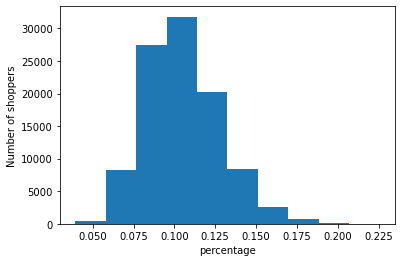

In [12]:
plt.hist(unique_products_per_shopper / products_per_shopper)
plt.xlabel("percentage")
plt.ylabel("Number of shoppers");

### Related to target

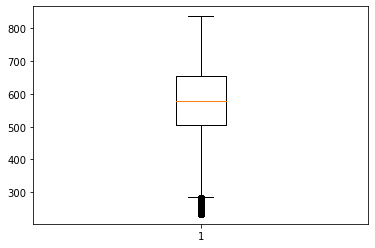

In [83]:
plt.boxplot(baskets.price);

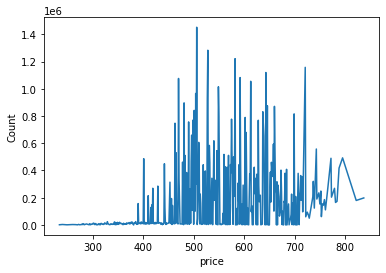

In [81]:
plt.plot(baskets.groupby('price').product.count())
plt.xlabel("price")
plt.ylabel("Count");

In [88]:
#which products are bought most often?
baskets.groupby('product').product.count().sort_values()

product
161     36875
233     45619
70      46148
27      46178
54      47392
        ...  
199    699511
101    706808
196    748950
76     908456
105    987902
Name: product, Length: 250, dtype: int64

### Coupons

each customer receives 5 coupons per week

In [67]:
sum(coupons.groupby(['shopper','week']).count().values != 5)

array([0, 0])

In [132]:
#How many of the coupons are used? (if product is bought -> counts as coupon is redempted)
#That is basically: How many entries from baskets appear in coupons
user_coupons = coupons[coupons.shopper < 2000]

user_coupons = pd.merge(user_coupons, train, on = ['week', 'shopper', 'product'])

In [133]:
user_coupons

,week,shopper,product,discount,prob_per_product,price,y,coupons_redempted
0,0,0,35,35,0.0,602,0,445
1,0,0,193,40,0.0,574,0,445
2,0,0,27,30,0.0,582,0,445
3,0,0,177,35,0.0,694,0,445
4,0,0,5,30,0.0,721,0,445
...,...,...,...,...,...,...,...,...
889995,88,1999,214,25,0.0,505,0,445
889996,88,1999,186,20,0.0,499,0,445
889997,88,1999,167,15,0.0,582,0,445
889998,88,1999,153,10,0.0,501,0,445


In [134]:
user_coupons = coupons[coupons.shopper < 2000]

user_coupons = pd.merge(user_coupons, train, on = ['week', 'shopper', 'product'])
coupons_redempted = user_coupons.groupby('shopper').shopper.count().reset_index(name = "coupons_redempted")


In [135]:
coupons_redempted

,shopper,coupons_redempted
0,0,445
1,1,445
2,2,445
3,3,445
4,4,445
...,...,...
1995,1995,445
1996,1996,445
1997,1997,445
1998,1998,445


## Baseline

In [169]:
#for now only use shoppers from prediction_index
train = baskets[(baskets.week < 89) & (baskets.shopper < 2000)]
test = baskets[(baskets.week == 89) & (baskets.shopper < 2000)].reset_index(drop = True)
test = pd.concat([test, prediction_index])
test = test[~test[['shopper','product']].duplicated() |  test[['price']].notnull().any(axis=1)]
test['week'] = 89
test['y'] = test.price.map(lambda x: 0 if math.isnan(x) else 1)
test.drop('price', inplace = True, axis = 1)

### Random Prediction

In [69]:
test['pred'] = np.random.uniform(0,1,len(test))

In [74]:
log_loss(test.y, test.pred)

0.9999512231043342

### Very simple prediction

#### Train

In [185]:
#for now lets take the max price
#prices = train.groupby('product').price.max()
train = baskets[(baskets.week < 89) & (baskets.shopper < 2000)]

#probability of each customer to buy a product
prob_per_product = train.groupby(['shopper', 'product']).shopper.count().div(train.groupby('shopper').shopper.count()).reset_index(name = "prob_per_product")



In [112]:
all_ = prediction_index.copy()
all_.week = 0
example = prediction_index.copy()
for i in range(1, 89):
    example.week = i
    all_ = pd.concat([all_, example])
all_
    
    

,week,shopper,product
0,0,0,0
1,0,0,1
2,0,0,2
3,0,0,3
4,0,0,4
...,...,...,...
499995,88,1999,245
499996,88,1999,246
499997,88,1999,247
499998,88,1999,248


In [304]:
random.seed(123)
train = baskets[(baskets.week < 89) & (baskets.shopper < 2000)]


false_data = all_.copy()
false_data['y'] = 0
#false_data = pd.merge(false_data, prices.reset_index(), on = ['product'], how = 'outer')


#coupons
user_coupons = coupons[coupons.shopper < 2000]
user_coupons = pd.merge(user_coupons, train, on = ['week', 'shopper', 'product'])
coupons_redempted = user_coupons.groupby('shopper').shopper.count().reset_index(name = "coupons_redempted")

#last purchase of product ()
#train['last_purchase'] = train.sort_values(['shopper','product','week']).groupby(['shopper','product']).week.transform(lambda x: x.rolling(window=2).apply(lambda y: y.iloc[1] - y.iloc[0]))
# numbers until first purchase are wrong
train['t'] = train.groupby(['shopper','product']).price.transform(lambda x: prox(x))

train['y'] = 1
train = pd.concat([train,false_data])

#keep if y = 1 or if not duplicated
train = train[~train[['shopper','product','week']].duplicated() |  train.y == 1]


train = pd.merge(train, coupons_redempted, on = ['shopper'])

train = pd.merge(prob_per_product,train, on = ['shopper', 'product'], how = 'outer')
train.prob_per_product.fillna(0, inplace = True)



/Users/enbo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/enbo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [268]:
sample = train[:1000][:].sort_values(['shopper', 'product', 'week'])

In [311]:
train[(train.shopper == 0) & (train['product'] == 4)]

,shopper,product,prob_per_product,week,price,t,y,coupons_redempted
0,0,4,0.010526,24,620.0,0.0,1,23
1,0,4,0.010526,40,620.0,0.0,1,23
2,0,4,0.010526,45,620.0,0.0,1,23
3,0,4,0.010526,51,620.0,0.0,1,23
4,0,4,0.010526,54,620.0,0.0,1,23
...,...,...,...,...,...,...,...,...
84,0,4,0.010526,84,NaN,NaN,0,23
85,0,4,0.010526,85,NaN,NaN,0,23
86,0,4,0.010526,86,NaN,NaN,0,23
87,0,4,0.010526,87,NaN,NaN,0,23


In [275]:
sample.last_purchase.notnull()

8      False
9      False
10     False
11     False
12     False
       ...  
996    False
997    False
998    False
999    False
979    False
Name: last_purchase, Length: 1000, dtype: bool

In [298]:
def prox(df):
    groupby_idx = df.notnull().cumsum()
    groupby = df.groupby(groupby_idx)
    return groupby.apply(lambda x: pd.Series(range(len(x)))).values

In [302]:
sample['t'] = sample.groupby(['shopper','product']).price.transform(lambda x: prox(x))

In [303]:
sample.head(50)

,shopper,product,prob_per_product,week,price,last_purchase,y,coupons_redempted,t
8,0,4,0.010526,0,NaN,NaN,0,23,0.0
9,0,4,0.010526,1,NaN,NaN,0,23,1.0
10,0,4,0.010526,2,NaN,NaN,0,23,2.0
11,0,4,0.010526,3,NaN,NaN,0,23,3.0
12,0,4,0.010526,4,NaN,NaN,0,23,4.0
13,0,4,0.010526,5,NaN,NaN,0,23,5.0
14,0,4,0.010526,6,NaN,NaN,0,23,6.0
15,0,4,0.010526,7,NaN,NaN,0,23,7.0
16,0,4,0.010526,8,NaN,NaN,0,23,8.0
17,0,4,0.010526,9,NaN,NaN,0,23,9.0


#### Test

In [190]:
test = pd.merge(test, prices.reset_index(), on = ['product'], how = 'outer')

test = pd.merge(prob_per_product,test, on = ['shopper', 'product'], how = 'outer')

test.prob_per_product = test.prob_per_product.map(lambda x: 0 if math.isnan(x) else x)

test = pd.merge(test, coupons_redempted, on = ['shopper'])

#### Model

In [192]:
features = ['prob_per_product', 'coupons_redempted']

##### Logistic regression

In [193]:

logModel = LogisticRegression()
logModel.fit(train[features], train.y)

pred = logModel.predict_proba(test[features])

log_loss(test.y, pred[:,1])

0.09053643542039079

##### Random Forest

In [47]:
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(train[features], train.y)

IndexError: too many indices for array

In [52]:
pred_rf = rf.predict_proba(test[features])
log_loss(test.y, pred_rf[:,1])

0.08305941974370457

##### XgBoost

### Next prediction

This time:
* time since last buy of a product



In [207]:
sample[(sample.shopper == 0) & (sample['product'] == 71)].week.rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])


0           NaN
764812      1.0
1530319     1.0
2294602     1.0
3824161     2.0
           ... 
63488993    1.0
64253690    1.0
65018515    1.0
66547264    2.0
68076682    2.0
Name: week, Length: 67, dtype: float64

In [221]:
sample.sort_values(['shopper','product','week']).groupby(['shopper','product']).week.rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])

shopper  product          
0        4        18360597     NaN
                  30596544    16.0
                  34421333     5.0
                  39009343     6.0
                  41304982     3.0
                              ... 
1999     249      29082842    27.0
                  29847770     1.0
                  32141478     3.0
                  32906501     1.0
                  42085793    12.0
Name: week, Length: 1378720, dtype: float64

In [224]:
 = sample[(sample.shopper < 100) & (sample['product'] < 10)].sort_values(['shopper','product','week']).groupby(['shopper','product']).week.transform(lambda x: x.rolling(window=2).apply(lambda y: y.iloc[1] - y.iloc[0]))

18360597     NaN
30596544    16.0
34421333     5.0
39009343     6.0
41304982     3.0
            ... 
58134072     2.0
59664874     2.0
60429435     1.0
61193876     1.0
65019264     5.0
Name: week, Length: 2178, dtype: float64

In [228]:
ss = sample[(sample.shopper < 100) & (sample['product'] < 10)].copy()

In [229]:
ss.sort_values(['shopper','product','week']).groupby(['shopper','product']).week.transform(lambda x: x.rolling(window=2).apply(lambda y: y.iloc[1] - y.iloc[0]))

18360597     NaN
30596544    16.0
34421333     5.0
39009343     6.0
41304982     3.0
            ... 
58134072     2.0
59664874     2.0
60429435     1.0
61193876     1.0
65019264     5.0
Name: week, Length: 2178, dtype: float64

In [231]:
ss['transformed'] = ss.sort_values(['shopper','product','week']).groupby(['shopper','product']).week.transform(lambda x: x.rolling(window=2).apply(lambda y: y.iloc[1] - y.iloc[0]))

In [233]:
ss.sort_values(['shopper','product','week'])

,week,shopper,product,price,transformed
18360597,24,0,4,620,NaN
30596544,40,0,4,620,16.0
34421333,45,0,4,620,5.0
39009343,51,0,4,620,6.0
41304982,54,0,4,620,3.0
...,...,...,...,...,...
58134072,76,99,5,721,2.0
59664874,78,99,5,721,2.0
60429435,79,99,5,721,1.0
61193876,80,99,5,721,1.0


In [230]:
ss

,week,shopper,product,price
24,0,3,6,568
83,0,11,1,560
96,0,12,4,620
132,0,17,8,669
147,0,19,6,568
...,...,...,...,...
68077207,89,75,1,560
68077285,89,86,8,669
68077312,89,90,1,560
68077329,89,92,4,620


## From Lecture (relevant for exam)


* we assume the products belong to categories, but categories are unknown
* we assume we buy one product out of a category
* categories are related (complements and subtitutes
    * e.g. cola vs mate 



* binary classification for each product is a bad idea
* assumption: one product out of each catgory is purchaed if the category is purchased
    * category as binary and within the category multinomial
    * softmax ? 
    


* products are bought in intervals
* discounts have different effects depending on the current probability of buying a product
* promotion for substitute decreases probability

* we have to look out for cases:
    * case 1: straight line: probability is always the same
    * case 2: straight line with peak down, because you bought product but a day later you want new
    * case 3: probability going up.

* how to model interdependencies between product or categories?
* C multinomial!

Features:
* Stockpiling? What is that
* price (and sensitivity): do changes in prices lead to changes in probability

Ideas for features:
* binary product purchase events (as vector)
* timessince last product purchase
* product purchase fequencies
* coupon redemption rate